<a href="https://colab.research.google.com/github/sergiopaniego/BehaviorStudio-experiments/blob/main/BS_LSTM_training_13_points_3_examples_sequences_extreme_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment with LSTMs training with preprocessed images of 13 points


In this experiment, I try training lstms networks with the dataset preprocessed with only 13 points of interest. 

In [ ]:
# When using Colab, check the GPU that is assigned and reload the runtime if its memory is low
!nvidia-smi

Tue Jun  8 07:16:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install W&B
%%capture
!pip install wandb

In [ ]:
# Import and login to W&B
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"
!ls "/content/drive/My Drive/complete_dataset.zip"
!unzip "/content/drive/My Drive/curves_only.zip"
!unzip "/content/drive/My Drive/complete_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: complete_dataset/Images/4655.png  
  inflating: complete_dataset/Images/13432.png  
  inflating: complete_dataset/Images/13393.png  
  inflating: complete_dataset/Images/14645.png  
  inflating: complete_dataset/Images/16896.png  
  inflating: complete_dataset/Images/4638.png  
  inflating: complete_dataset/Images/12695.png  
  inflating: complete_dataset/Images/13074.png  
  inflating: complete_dataset/Images/16020.png  
  inflating: complete_dataset/Images/15454.png  
  inflating: complete_dataset/Images/690.png  
  inflating: complete_dataset/Images/8168.png  
  inflating: complete_dataset/Images/4244.png  
  inflating: complete_dataset/Images/16078.png  
  inflating: complete_dataset/Images/6062.png  
  inflating: complete_dataset/Images/7468.png  
  inflating: complete_dataset/Images/1326.png  
  inflating: complete_dataset/Images/2106.png  
  inflating: complete_dataset/Images/585.png  
  inflating: complete_dataset/

In [ ]:
'''
  NORMALIZED DATASET 13 points!!
'''
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import json


def load_data(folder):
    name_folder = '/content/' + folder + '/Images/'
    list_images = glob.glob(name_folder + '*')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[4].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    file = open(name_file, 'r')
    data = file.read()
    file.close()
    return images, data


def load_data_new_dataset(folder):
    name_folder = '/content/' + folder + '/'
    list_images = glob.glob(name_folder + '*.png')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data


def get_images(list_images, type_image, array_imgs, image_type):
    # Read the images
    broken_imgs = []
    for img_number, name in enumerate(list_images):
      #if img_number < 100:
        img = cv2.imread(name)
        if image_type == 'rgb':
          img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif image_type == 'bgr':
          img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        if type_image == 'cropped':
            img = img[240:480, 0:640]
        img = cv2.resize(img, (int(img.shape[1] / 4), int(img.shape[0] / 4)))

        lower = np.array([0,150,70])
        upper = np.array([0, 255, 255])
        # lower = np.array([0, 110, 15])
        # upper = np.array([179, 255, 25])
        mask = cv2.inRange(img, lower, upper)
        
        img_points = [mask[0], mask[4], mask[9], mask[14], mask[19], mask[24], mask[29], mask[34], mask[39], mask[44], mask[49], mask[54], mask[59]]

        new_img_points = []
        # Get center point from line where the mask 
        for img_point in img_points:
          mask_points = []
          for x, point in enumerate(img_point):
            if point == 255:
              mask_points.append(x)
          if len(mask_points) > 0:
            new_img_points.append(mask_points[len(mask_points)//2])
          else:
            #new_img_points.append(-1)
            new_img_points.append(0)

        #if new_img_points != [0, 0, 0, 0, 0]:
        #if new_img_points != [0, 0, 0, 0]:
        #if new_img_points != [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]:
        #  array_imgs.append(new_img_points)
        #else:
        #  broken_imgs.append(img_number)

        array_imgs.append(new_img_points)

    return array_imgs, broken_imgs

def parse_json(data, array, broken_imgs_list):
    # Process json
    data_parse = data.split('}')[:-1]
    for number, d in enumerate(data_parse):
      #if number < 100:
        if number not in broken_imgs_list:
          v = d.split('"v": ')[1]
          d_parse = d.split(', "v":')[0]
          w = d_parse.split(('"w": '))[1]
          array.append((float(v), float(w)))

    return array


def parse_json_new_dataset(data, array):
    # Process json
    for key, value in data.items():
      print(data)
      print(data[key])
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))

    return array


def preprocess_data(array, imgs):
    # Data augmentation
    # Take the image and just flip it and negate the measurement
    flip_imgs = []
    array_flip = []
    for i in range(len(array)):
        img_flip = []
        for a in imgs[i]:
          if a == 0:
            img_flip.append(0)
          else:
            img_flip.append(160 - a)

        flip_imgs.append(img_flip)
        array_flip.append((array[i][0], -array[i][1]))
    new_array = array + array_flip
    new_array_imgs = imgs + flip_imgs
    return new_array, new_array_imgs


def add_extreme_data(array, imgs):
    print('ADD EXTREME DATA')
    print(len(imgs))
    for i in range(0, len(array)):
        if abs(array[i][1]) >= 1:
            if abs(array[i][1]) >= 2:
                num_iter = 10
            else:
                num_iter = 5
            for j in range(0, num_iter):
                array.append(array[i])
                imgs.append(imgs[i])
        if float(array[i][0]) <= 2:
            for j in range(0, 1):
                array.append(array[i])
                imgs.append(imgs[i])
    print(len(imgs))
    return array, imgs


# Load data
images, data = load_data('complete_dataset')
images_curve, data_curve = load_data('curves_only')
#images_simple, data_simple = load_data_new_dataset('simple_circuit_dataset')
#images_many_curves, data_many_curves = load_data_new_dataset('many_curves_dataset')

# CHANGE type_image
type_image = 'cropped'
#type_image='normal'

# Preprocess images
array_imgs = []
array_imgs, broken_imgs_complete = get_images(images, type_image, array_imgs, 'bgr')
array_imgs, broken_imgs_curve = get_images(images_curve, type_image, array_imgs, 'bgr')
#array_imgs = get_images(images_simple, type_image, array_imgs, 'rgb')
#array_imgs = get_images(images_many_curves, type_image, array_imgs, 'rgb')
# Preprocess json
array_annotations = []
print(len(broken_imgs_complete))
print(len(broken_imgs_curve))
array_annotations = parse_json(data, array_annotations, broken_imgs_complete)
array_annotations = parse_json(data_curve, array_annotations, broken_imgs_curve)
#array_annotations = parse_json_new_dataset(data_simple, array_annotations)
#array_annotations = parse_json_new_dataset(data_many_curves, array_annotations)


if type_image == 'cropped':
    img_shape = (65, 160, 3)
else:
    img_shape = (120, 160, 3)

print(len(array_annotations))

# Adapt the data
array_annotations, array_imgs = preprocess_data(array_annotations, array_imgs)
#array_annotations, array_imgs = add_extreme_data(array_annotations, array_imgs)

normalized_imgs = []
for img in array_imgs:
  new_img = []
  for x in img:
    x = (x - 0) / 160 * 1 + 0
    new_img.append(x)

  normalized_imgs.append(new_img)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)

print(normalized_Y)

old_min = normalized_Y.min()
print('NEW MIN -> ' + str(old_min))
old_range = normalized_Y.max() - old_min
print('NEW RANGE -> ' + str(old_range))

old_min = array_annotations_w.min()
print('OLD MIN -> ' + str(old_min))
old_range = array_annotations_w.max() - old_min
print('OLD RANGE -> ' + str(old_range))


'''
new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)
'''

normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)
# array_annotations = normalized_annotations



#array_annotations_v = []
#array_annotations_w = []
normalized_X = []
normalized_Y = []
# END NORMALIZE DATA
print(len(normalized_imgs))
print(len(normalized_annotations))

array_imgs = normalized_imgs
array_annotations = normalized_annotations
#split_test_train_value = 0.30
#images_train, images_validation, annotations_train, annotations_validation = train_test_split(normalized_imgs, normalized_annotations, test_size=split_test_train_value, random_state=42, shuffle=False)


# Adapt the data
#images_train = np.stack(images_train, axis=0)
#annotations_train = np.stack(annotations_train, axis=0)
#images_validation = np.stack(images_validation, axis=0)
#annotations_validation = np.stack(annotations_validation, axis=0)

#print(annotations_train[0])
#print(annotations_train.shape)
#print(annotations_validation.shape)

#video = np.stack(array_imgs, axis=0)
#print(images_train.shape)
#print(images_validation.shape)

['/content/complete_dataset/Images/12206.png', '/content/complete_dataset/Images/3018.png', '/content/complete_dataset/Images/3682.png', '/content/complete_dataset/Images/12168.png', '/content/complete_dataset/Images/11225.png', '/content/complete_dataset/Images/11764.png', '/content/complete_dataset/Images/2571.png', '/content/complete_dataset/Images/11166.png', '/content/complete_dataset/Images/6068.png', '/content/complete_dataset/Images/5220.png', '/content/complete_dataset/Images/8476.png', '/content/complete_dataset/Images/6509.png', '/content/complete_dataset/Images/13986.png', '/content/complete_dataset/Images/9404.png', '/content/complete_dataset/Images/12503.png', '/content/complete_dataset/Images/2251.png', '/content/complete_dataset/Images/15182.png', '/content/complete_dataset/Images/3263.png', '/content/complete_dataset/Images/2654.png', '/content/complete_dataset/Images/9753.png', '/content/complete_dataset/Images/14562.png', '/content/complete_dataset/Images/17136.png',

In [ ]:
# SEPARATE DATASET INTO SEQUENCES TO FIT BATCH SIZES
# 1
array_1_img = [] 
array_1_ann = []
# 2
array_2_img = [] 
array_2_ann = []
# 3
array_3_img = [] 
array_3_ann = []
# 4
array_4_img = [] 
array_4_ann = []
# 5
array_5_img = [] 
array_5_ann = []
# 6
array_6_img = [] 
array_6_ann = []
# 7
array_7_img = [] 
array_7_ann = []
# 8
array_8_img = [] 
array_8_ann = []
# 9
array_9_img = [] 
array_9_ann = []
# 10
array_10_img = [] 
array_10_ann = []
# 11
array_11_img = [] 
array_11_ann = []
# 12
array_12_img = [] 
array_12_ann = []
# 13
array_13_img = [] 
array_13_ann = []
# 14
array_14_img = [] 
array_14_ann = []
# 15
array_15_img = [] 
array_15_ann = []
# 16
array_16_img = [] 
array_16_ann = []
# 17
array_17_img = [] 
array_17_ann = []
# 18
array_18_img = [] 
array_18_ann = []
# 19
array_19_img = [] 
array_19_ann = []
# 20
array_20_img = [] 
array_20_ann = []
# 21
array_21_img = [] 
array_21_ann = []
# 22
array_22_img = [] 
array_22_ann = []
# 23
array_23_img = [] 
array_23_ann = []
# 24
array_24_img = [] 
array_24_ann = []
# 25
array_25_img = [] 
array_25_ann = []
# 26
array_26_img = [] 
array_26_ann = []
# 27
array_27_img = [] 
array_27_ann = []
# 28
array_28_img = [] 
array_28_ann = []
# 29
array_29_img = [] 
array_29_ann = []
# 30
array_30_img = [] 
array_30_ann = []
# 31
array_31_img = [] 
array_31_ann = []
# 32
array_32_img = [] 
array_32_ann = []
# 33
array_33_img = [] 
array_33_ann = []


'''
Dataset completo:

3744-3745
5066-5067
9720-9721
10387-10388
10695-10696
11283-11284
11354-11355
11492-11493
11980-11981
12618-12619
13231-13232
14107-14108
15790-15791
16732-16762 -> giro total???
16795-16796
16796-17341
Dataset muchas curvas:
(17341+...)
3156-3157

Cortes: 
1. 0-3700 *
2. 3745-5045 *
3. 5067-9717 *
4. 9721-10371 *
5. 10388-10688 *
6. 10696-11246 *
7. 11284-11334 *
8. 11355-11455 *
9. 11493-11943 *
10. 11981-12581 *
11. 12619-13219 *
12. 13232-14082 *
13. 14108-15758 *
14. 15791-16691 *
15. 16796-17296 *
16. 17341-20491 *
17. 20498-22598 *
Repetición cortes:
1. 22609-26309 *
2. 26354-27654 *
3. 27676-32326 *
4. 32330-32960 *
5. 32997-33297 *
6. 33305-33855 *
7. 33893-33943 *
8. 33964-34064 *
9. 34102-34552 *
10. 34590-35190 *
11. 35228-35828 *
12. 35841-36691 *
13. 36717-38367 *
14. 38400-39300 *
15. 39405-39905 *
16. 39950-43100 *
17. 43107-45207 *


'''


for i in range(0, 3700):
  array_1_img.append(array_imgs[i])
  array_1_ann.append(array_annotations[i])
for i in range(3745, 5045):
  array_2_img.append(array_imgs[i])
  array_2_ann.append(array_annotations[i])
for i in range(5067, 9717):
  array_3_img.append(array_imgs[i])
  array_3_ann.append(array_annotations[i])
for i in range(9721, 10371):
  array_4_img.append(array_imgs[i])
  array_4_ann.append(array_annotations[i])
for i in range(10388, 10688):
  array_5_img.append(array_imgs[i])
  array_5_ann.append(array_annotations[i])
for i in range(10696, 11246):
  array_6_img.append(array_imgs[i])
  array_6_ann.append(array_annotations[i])
for i in range(11284, 11334):
  array_7_img.append(array_imgs[i])
  array_7_ann.append(array_annotations[i])
for i in range(11355, 11455):
  array_8_img.append(array_imgs[i])
  array_8_ann.append(array_annotations[i])
for i in range(11493, 11943):
  array_9_img.append(array_imgs[i])
  array_9_ann.append(array_annotations[i])
for i in range(11981, 12581):
  array_10_img.append(array_imgs[i])
  array_10_ann.append(array_annotations[i])
for i in range(12619, 13219):
  array_11_img.append(array_imgs[i])
  array_11_ann.append(array_annotations[i])
for i in range(13232, 14082):
  array_12_img.append(array_imgs[i])
  array_12_ann.append(array_annotations[i])
for i in range(14108, 15758):
  array_13_img.append(array_imgs[i])
  array_13_ann.append(array_annotations[i])
for i in range(15791, 17296):
  array_14_img.append(array_imgs[i])
  array_14_ann.append(array_annotations[i])
for i in range(17341, 20491):
  array_15_img.append(array_imgs[i])
  array_15_ann.append(array_annotations[i])
for i in range(20498, 22598):
  array_16_img.append(array_imgs[i])
  array_16_ann.append(array_annotations[i])
for i in range(22609, 26309):
  array_17_img.append(array_imgs[i])
  array_17_ann.append(array_annotations[i])
for i in range(26354, 27654):
  array_18_img.append(array_imgs[i])
  array_18_ann.append(array_annotations[i])
for i in range(27676, 32326):
  array_19_img.append(array_imgs[i])
  array_19_ann.append(array_annotations[i])
for i in range(32330, 32960):
  array_20_img.append(array_imgs[i])
  array_20_ann.append(array_annotations[i])
for i in range(32997, 33297):
  array_21_img.append(array_imgs[i])
  array_21_ann.append(array_annotations[i])
for i in range(33305, 33855):
  array_22_img.append(array_imgs[i])
  array_22_ann.append(array_annotations[i])
for i in range(33893, 33943):
  array_23_img.append(array_imgs[i])
  array_23_ann.append(array_annotations[i])
for i in range(33964, 34064):
  array_24_img.append(array_imgs[i])
  array_24_ann.append(array_annotations[i])
for i in range(34102, 34552):
  array_25_img.append(array_imgs[i])
  array_25_ann.append(array_annotations[i])
for i in range(34590, 35190):
  array_26_img.append(array_imgs[i])
  array_26_ann.append(array_annotations[i])
for i in range(35228, 35828):
  array_27_img.append(array_imgs[i])
  array_27_ann.append(array_annotations[i])
for i in range(35841, 36691):
  array_28_img.append(array_imgs[i])
  array_28_ann.append(array_annotations[i])
for i in range(36717, 38367):
  array_29_img.append(array_imgs[i])
  array_29_ann.append(array_annotations[i])
for i in range(38400, 39300):
  array_30_img.append(array_imgs[i])
  array_30_ann.append(array_annotations[i])
for i in range(39405, 39905):
  array_31_img.append(array_imgs[i])
  array_31_ann.append(array_annotations[i])
for i in range(39950, 43100):
  array_32_img.append(array_imgs[i])
  array_32_ann.append(array_annotations[i])
for i in range(43107, 45202):
  array_33_img.append(array_imgs[i])
  array_33_ann.append(array_annotations[i])




'''
[21, 0, 12, 2, 10, 26, 25, 7, 29, 15, 30, 28, 27, 3, 4, 24, 32, 6, 19, 8, 20, 14, 17, 16, 31, 13, 9, 1, 5, 18, 22, 11, 23]
'''
array_x = []
array_x.append(array_1_img)
array_x.append(array_2_img)
array_x.append(array_3_img)
array_x.append(array_4_img)
array_x.append(array_5_img)
array_x.append(array_6_img)
array_x.append(array_7_img)
array_x.append(array_8_img)
array_x.append(array_9_img)
array_x.append(array_10_img)
array_x.append(array_11_img)
array_x.append(array_12_img)
#array_x.append(array_13_img)
#array_x.append(array_14_img)
array_x.append(array_15_img)
array_x.append(array_16_img)
array_x.append(array_17_img)
array_x.append(array_18_img)
array_x.append(array_19_img)
array_x.append(array_20_img)
array_x.append(array_21_img)
array_x.append(array_22_img)
array_x.append(array_23_img)
array_x.append(array_24_img)
array_x.append(array_25_img)
array_x.append(array_26_img)
array_x.append(array_27_img)
array_x.append(array_28_img)
#array_x.append(array_29_img)
#array_x.append(array_30_img)
#array_x.append(array_31_img)
array_x.append(array_32_img)
array_x.append(array_33_img)


array_y = []
array_y.append(array_1_ann)
array_y.append(array_2_ann)
array_y.append(array_3_ann)
array_y.append(array_4_ann)
array_y.append(array_5_ann)
array_y.append(array_6_ann)
array_y.append(array_7_ann)
array_y.append(array_8_ann)
array_y.append(array_9_ann)
array_y.append(array_10_ann)
array_y.append(array_11_ann)
array_y.append(array_12_ann)
#array_y.append(array_13_ann)
#array_y.append(array_14_ann)
array_y.append(array_15_ann)
array_y.append(array_16_ann)
array_y.append(array_17_ann)
array_y.append(array_18_ann)
array_y.append(array_19_ann)
array_y.append(array_20_ann)
array_y.append(array_21_ann)
array_y.append(array_22_ann)
array_y.append(array_23_ann)
array_y.append(array_24_ann)
array_y.append(array_25_ann)
array_y.append(array_26_ann)
array_y.append(array_27_ann)
array_y.append(array_28_ann)
#array_y.append(array_29_ann)
#array_y.append(array_30_ann)
#array_y.append(array_31_ann)
array_y.append(array_32_ann)
array_y.append(array_33_ann)

print(len(array_x))
print(len(array_y))


'''
array_x = [array_1_img,array_2_img,array_3_img,array_4_img,array_5_img,array_6_img, \
           array_7_img,array_8_img,array_9_img,array_10_img,array_11_img,array_12_img, \
           array_13_img,array_14_img,array_15_img,array_16_img,array_17_img,array_18_img, \
           array_19_img,array_20_img,array_21_img,array_22_img,array_23_img,array_24_img, \
           array_25_img,array_26_img,array_27_img,array_28_img,array_29_img,array_30_img, \
           array_31_img,array_32_img,array_33_img]
array_y = [array_1_ann,array_2_ann,array_3_ann,array_4_ann,array_5_ann,array_6_ann, \
           array_7_ann,array_8_ann,array_9_ann,array_10_ann,array_11_ann,array_12_ann, \
           array_13_ann,array_14_ann,array_15_ann,array_16_ann,array_17_ann,array_18_ann, \
           array_19_ann,array_20_ann,array_21_ann,array_22_ann,array_23_ann,array_24_ann, \
           array_25_ann,array_26_ann,array_27_ann,array_28_ann,array_29_ann,array_30_ann, \
           array_31_ann,array_32_ann,array_33_ann]




print(len(array_x))
print(len(array_y))
'''


'''
import random
random_sort = random.sample(range(0, 33), 33)
print(len(random_sort))
print(random_sort)

new_array_imgs = []
new_array_annotations = []
for numb in random_sort:
  new_array_imgs += array_x[numb]
  new_array_annotations += array_y[numb]


print(len(new_array_imgs))
print(len(new_array_annotations))
'''

28
28


'\nimport random\nrandom_sort = random.sample(range(0, 33), 33)\nprint(len(random_sort))\nprint(random_sort)\n\nnew_array_imgs = []\nnew_array_annotations = []\nfor numb in random_sort:\n  new_array_imgs += array_x[numb]\n  new_array_annotations += array_y[numb]\n\n\nprint(len(new_array_imgs))\nprint(len(new_array_annotations))\n'

In [ ]:

for x, array_img in enumerate(array_x):
  contador = 0
  for i, image in enumerate(array_img):
    if image == [0,0,0,0,0,0,0,0,0,0,0,0,0]:
      contador += 1
  print(str(x+1) + ' - TOTAL IMGS: ' + str(len(array_img)) + ' BROKEN IMAGES: ' + str(contador))



1 - TOTAL IMGS: 3700 BROKEN IMAGES: 0
2 - TOTAL IMGS: 1300 BROKEN IMAGES: 0
3 - TOTAL IMGS: 4650 BROKEN IMAGES: 0
4 - TOTAL IMGS: 650 BROKEN IMAGES: 0
5 - TOTAL IMGS: 300 BROKEN IMAGES: 0
6 - TOTAL IMGS: 550 BROKEN IMAGES: 0
7 - TOTAL IMGS: 50 BROKEN IMAGES: 0
8 - TOTAL IMGS: 100 BROKEN IMAGES: 0
9 - TOTAL IMGS: 450 BROKEN IMAGES: 0
10 - TOTAL IMGS: 600 BROKEN IMAGES: 0
11 - TOTAL IMGS: 600 BROKEN IMAGES: 0
12 - TOTAL IMGS: 850 BROKEN IMAGES: 2
13 - TOTAL IMGS: 3150 BROKEN IMAGES: 0
14 - TOTAL IMGS: 2100 BROKEN IMAGES: 1
15 - TOTAL IMGS: 3700 BROKEN IMAGES: 0
16 - TOTAL IMGS: 1300 BROKEN IMAGES: 0
17 - TOTAL IMGS: 4650 BROKEN IMAGES: 0
18 - TOTAL IMGS: 630 BROKEN IMAGES: 0
19 - TOTAL IMGS: 300 BROKEN IMAGES: 0
20 - TOTAL IMGS: 550 BROKEN IMAGES: 0
21 - TOTAL IMGS: 50 BROKEN IMAGES: 0
22 - TOTAL IMGS: 100 BROKEN IMAGES: 0
23 - TOTAL IMGS: 450 BROKEN IMAGES: 0
24 - TOTAL IMGS: 600 BROKEN IMAGES: 0
25 - TOTAL IMGS: 600 BROKEN IMAGES: 0
26 - TOTAL IMGS: 850 BROKEN IMAGES: 2
27 - TOTAL IMGS

In [ ]:

new_array_img = []
new_array_ann = []

for x, array_img in enumerate(array_x):
  sequence_array_imgs = []
  sequence_array_anns = []
  x_1 = []
  x_2 = []
  x_3 = []


  for i, image in enumerate(array_img):
    x_1.insert(0, image)
    if i > 0:
      x_2.insert(0, image)
    if i > 1:
      x_3.insert(0, image)

    if len(x_1) == 3:
      sequence_array_imgs.append(x_1)
      x_1 = []
    if len(x_2) == 3:
      sequence_array_imgs.append(x_2)
      x_2 = []
    if len(x_3) == 3:
      sequence_array_imgs.append(x_3)
      x_3 = []

  print(len(array_img))
  print(len(sequence_array_imgs))
  new_array_img.append(sequence_array_imgs)
  # new_array_y = np.array(array_y[x])
  new_array_y = array_y[x]
  new_array_y = new_array_y[2::1]
  print(len(new_array_y))
  new_array_ann.append(new_array_y)


print(len(new_array_img))
print(len(new_array_img[0]))
print(len(new_array_ann))
print(len(new_array_ann[0]))

   
array_x = [new_array_img[0], new_array_img[1], new_array_img[2], new_array_img[3], new_array_img[4], new_array_img[5],
            new_array_img[6], new_array_img[7], new_array_img[8], new_array_img[9], new_array_img[10], new_array_img[11],
            new_array_img[12], new_array_img[13], new_array_img[14], new_array_img[15], new_array_img[16], new_array_img[17],
            new_array_img[18], new_array_img[19], new_array_img[20], new_array_img[21], new_array_img[22], new_array_img[23],
            new_array_img[24], new_array_img[25], new_array_img[26], new_array_img[27]]


array_y = [new_array_ann[0], new_array_ann[1], new_array_ann[2], new_array_ann[3], new_array_ann[4], new_array_ann[5],
            new_array_ann[6], new_array_ann[7], new_array_ann[8], new_array_ann[9], new_array_ann[10], new_array_ann[11],
            new_array_ann[12], new_array_ann[13], new_array_ann[14], new_array_ann[15], new_array_ann[16], new_array_ann[17],
            new_array_ann[18], new_array_ann[19], new_array_ann[20], new_array_ann[21], new_array_ann[22], new_array_ann[23],
            new_array_ann[24], new_array_ann[25], new_array_ann[26], new_array_ann[27]]


import random
random_sort = random.sample(range(0, 28), 28)
print(len(random_sort))
print(random_sort)

new_array_imgs = []
new_array_annotations = []
for numb in random_sort:
  #print(numb)
  #print(type(array_x[numb]))
  #print(type(array_y[numb]))
  new_array_imgs += array_x[numb]
  new_array_annotations += array_y[numb]


print(len(new_array_imgs))
print(len(new_array_annotations))


X = np.array(new_array_imgs)
Y = np.array(new_array_annotations)

split_test_train_value = 0.30
images_train, images_validation, annotations_train, annotations_validation = train_test_split(X, Y, test_size=split_test_train_value, random_state=42, shuffle=False)

print(annotations_train.shape)
print(annotations_validation.shape)

print(images_train.shape)
print(images_validation.shape)


print(images_train[0])
  

3700
3698
3698
1300
1298
1298
4650
4648
4648
650
648
648
300
298
298
550
548
548
50
48
48
100
98
98
450
448
448
600
598
598
600
598
598
850
848
848
3150
3148
3148
2100
2098
2098
3700
3698
3698
1300
1298
1298
4650
4648
4648
630
628
628
300
298
298
550
548
548
50
48
48
100
98
98
450
448
448
600
598
598
600
598
598
850
848
848
3150
3148
3148
2095
2093
2093
28
3698
28
3698
28
[17, 6, 23, 10, 19, 16, 14, 5, 25, 7, 22, 12, 15, 1, 21, 0, 27, 18, 2, 24, 26, 13, 20, 3, 4, 9, 8, 11]
38019
38019
(26613, 2)
(11406, 2)
(26613, 3, 13)
(11406, 3, 13)
[[0.      0.44375 0.40625 0.36875 0.3375  0.3     0.2625  0.23125 0.19375
  0.15625 0.11875 0.1     0.0875 ]
 [0.      0.45    0.43125 0.4125  0.4     0.375   0.35625 0.3375  0.325
  0.30625 0.28125 0.2625  0.24375]
 [0.      0.4625  0.45625 0.45625 0.45625 0.45    0.45    0.45    0.44375
  0.44375 0.4375  0.4375  0.4375 ]]


In [ ]:
sample_weight = np.ones(shape=(len(annotations_train),))

'''
print(annotations_train[:,1])
sample_weight[annotations_train[:,1] >= 0.75] = 1.5
sample_weight[annotations_train[:,1] <= 0.25] = 1.5

sample_weight[annotations_train[:,1] >= 0.85] = 5.0
sample_weight[annotations_train[:,1] <= 0.15] = 5.0

sample_weight[annotations_train[:,1] >= 0.95] = 10.0
sample_weight[annotations_train[:,1] <= 0.05] = 10.0

print(sample_weight[annotations_train[:,1] >= 0.75])
print(len(sample_weight[annotations_train[:,1] >= 0.75]))
print(sample_weight[annotations_train[:,1] <= 0.25])
print(len(sample_weight[annotations_train[:,1] <= 0.25]))

print(sample_weight[annotations_train[:,1] >= 0.85])
print(len(sample_weight[annotations_train[:,1] >= 0.85]))
print(sample_weight[annotations_train[:,1] <= 0.15])
print(len(sample_weight[annotations_train[:,1] <= 0.15]))

print(sample_weight[annotations_train[:,1] >= 0.95])
print(len(sample_weight[annotations_train[:,1] >= 0.95]))
print(sample_weight[annotations_train[:,1] <= 0.05])
print(len(sample_weight[annotations_train[:,1] <= 0.05]))
'''

print(annotations_train[:,1])
sample_weight[annotations_train[:,1] >= 0.75] = 1
sample_weight[annotations_train[:,1] <= 0.25] = 1

sample_weight[annotations_train[:,1] >= 0.85] = 1
sample_weight[annotations_train[:,1] <= 0.15] = 1

sample_weight[annotations_train[:,1] >= 0.95] = 1
sample_weight[annotations_train[:,1] <= 0.05] = 1

print(sample_weight[annotations_train[:,1] >= 0.75])
print(len(sample_weight[annotations_train[:,1] >= 0.75]))
print(sample_weight[annotations_train[:,1] <= 0.25])
print(len(sample_weight[annotations_train[:,1] <= 0.25]))

print(sample_weight[annotations_train[:,1] >= 0.85])
print(len(sample_weight[annotations_train[:,1] >= 0.85]))
print(sample_weight[annotations_train[:,1] <= 0.15])
print(len(sample_weight[annotations_train[:,1] <= 0.15]))

print(sample_weight[annotations_train[:,1] >= 0.95])
print(len(sample_weight[annotations_train[:,1] >= 0.95]))
print(sample_weight[annotations_train[:,1] <= 0.05])
print(len(sample_weight[annotations_train[:,1] <= 0.05]))




print('----')
for ann in annotations_train:
  if ann[1] >= 0.9:
    print(ann)
  if ann[1] <= 0.1:
    print(ann)
print('----')
for ann in annotations_validation:
  if ann[1] >= 0.9:
    print(ann)
  if ann[1] <= 0.1:
    print(ann)
print('----')
print(sample_weight)

[0.528181   0.52840581 0.52919263 ... 0.49065451 0.4853234  0.48488985]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
154
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 

28
0
extreme_examples -> 0
array_anns length -> 3698
0.0


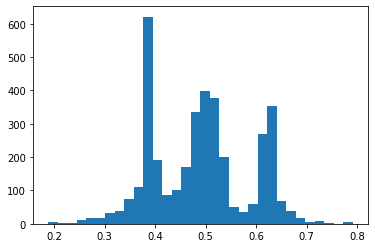

1
extreme_examples -> 0
array_anns length -> 1298
0.0


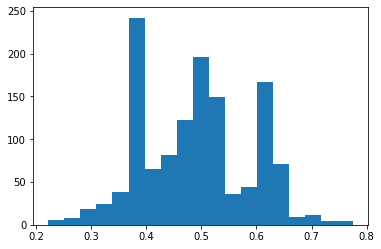

2
extreme_examples -> 0
array_anns length -> 4648
0.0


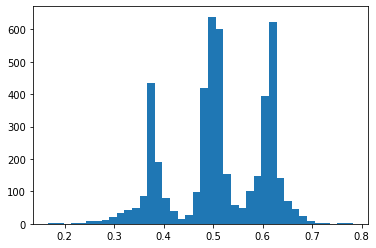

3
extreme_examples -> 9
array_anns length -> 648
0.013888888888888888


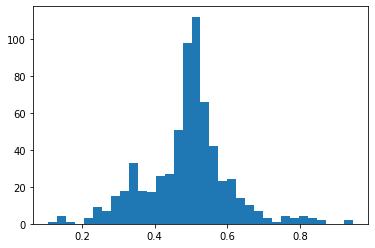

4
extreme_examples -> 4
array_anns length -> 298
0.013422818791946308


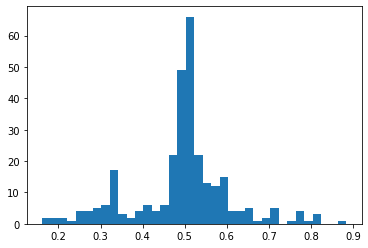

5
extreme_examples -> 9
array_anns length -> 548
0.016423357664233577


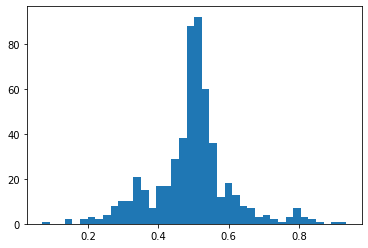

6
extreme_examples -> 0
array_anns length -> 48
0.0


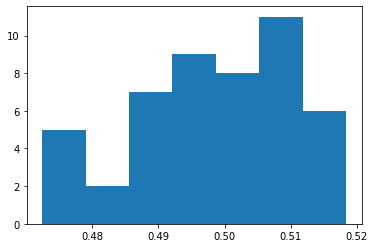

7
extreme_examples -> 0
array_anns length -> 98
0.0


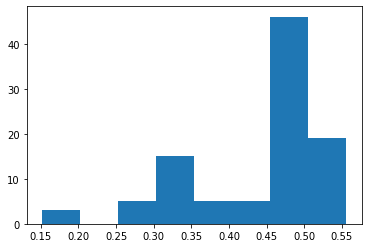

8
extreme_examples -> 6
array_anns length -> 448
0.013392857142857142


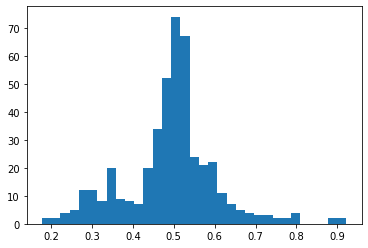

9
extreme_examples -> 12
array_anns length -> 598
0.020066889632107024


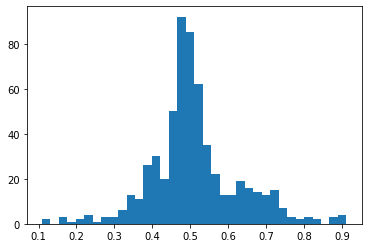

10
extreme_examples -> 10
array_anns length -> 598
0.016722408026755852


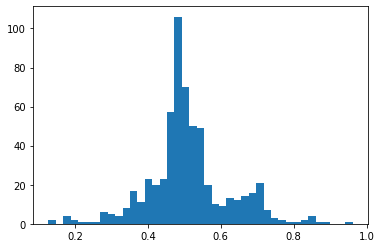

11
extreme_examples -> 10
array_anns length -> 848
0.01179245283018868


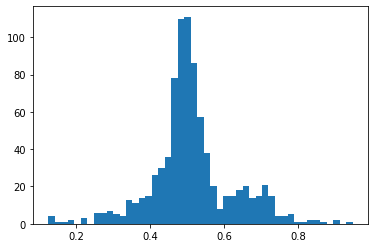

12
extreme_examples -> 6
array_anns length -> 3148
0.0019059720457433292


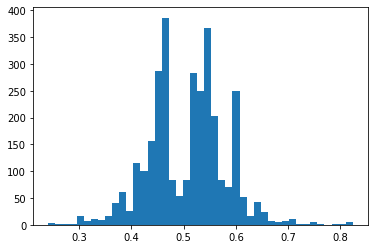

13
extreme_examples -> 2
array_anns length -> 2098
0.0009532888465204957


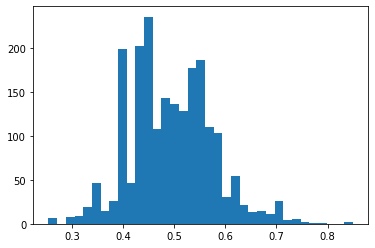

14
extreme_examples -> 4
array_anns length -> 3698
0.001081665765278529


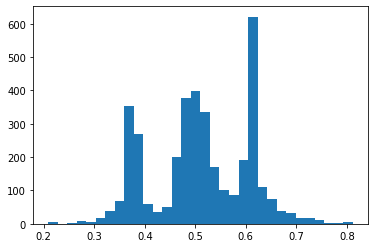

15
extreme_examples -> 0
array_anns length -> 1298
0.0


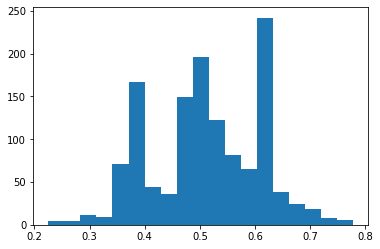

16
extreme_examples -> 6
array_anns length -> 4648
0.0012908777969018934


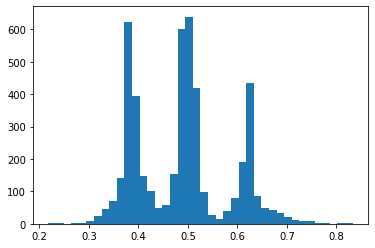

17
extreme_examples -> 6
array_anns length -> 628
0.009554140127388535


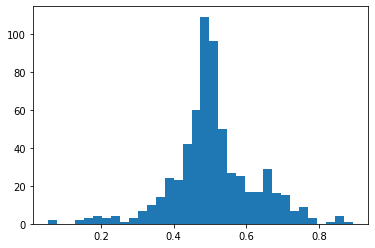

18
extreme_examples -> 4
array_anns length -> 298
0.013422818791946308


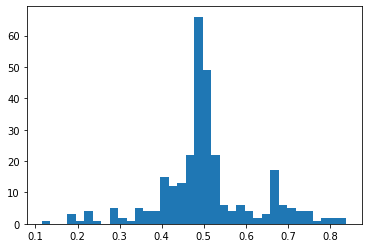

19
extreme_examples -> 5
array_anns length -> 548
0.009124087591240875


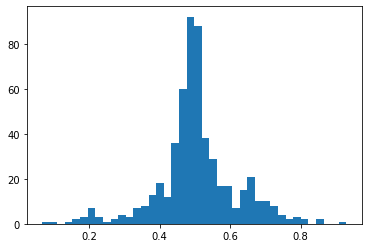

20
extreme_examples -> 0
array_anns length -> 48
0.0


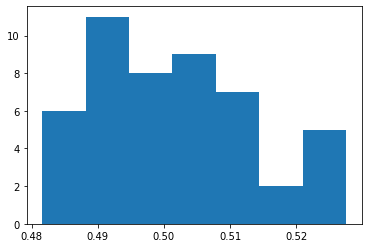

21
extreme_examples -> 3
array_anns length -> 98
0.030612244897959183


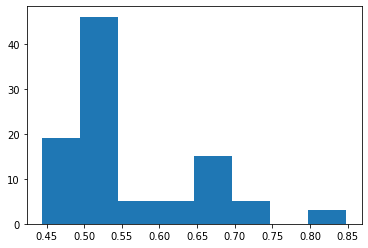

22
extreme_examples -> 2
array_anns length -> 448
0.004464285714285714


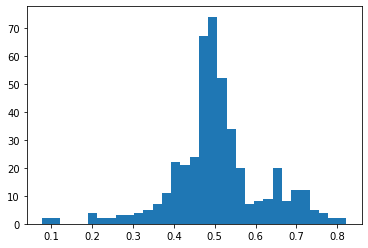

23
extreme_examples -> 7
array_anns length -> 598
0.011705685618729096


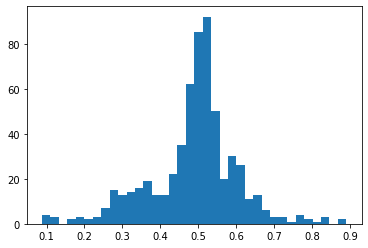

24
extreme_examples -> 7
array_anns length -> 598
0.011705685618729096


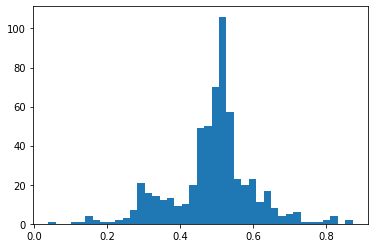

25
extreme_examples -> 8
array_anns length -> 848
0.009433962264150943


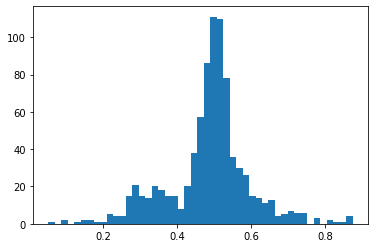

26
extreme_examples -> 0
array_anns length -> 3148
0.0


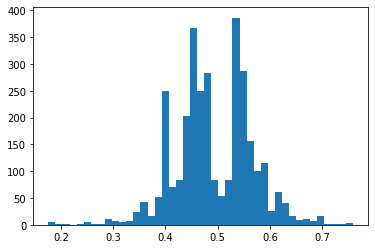

27
extreme_examples -> 0
array_anns length -> 2093
0.0


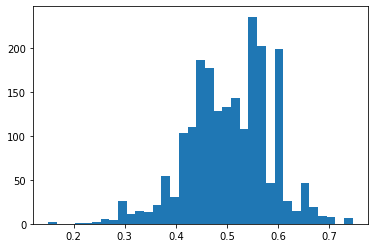

In [ ]:
print(len(new_array_ann))


for x, array_anns in enumerate(new_array_ann):
  print(x)
  ann_y = []
  extreme_examples = 0
  for ann in array_anns:
    ann_y.append(ann[1])
    if ann[1] > 0.8 or ann[1] < -0.8:
      extreme_examples += 1
  print('extreme_examples -> ' + str(extreme_examples))
  print('array_anns length -> ' + str(len(array_anns)))
  print(extreme_examples / len(array_anns))
  n, bins, patches = plt.hist(x=ann_y, bins='auto')
  plt.show()


--- ANNOTATIONS DATA ---


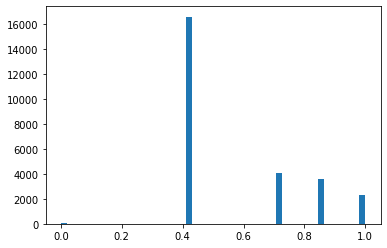

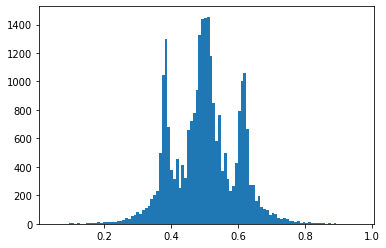

--- VALIDATION DATA ---


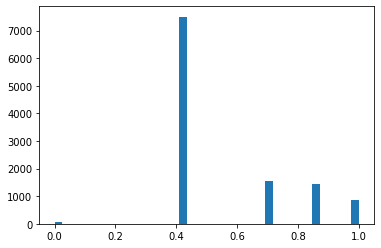

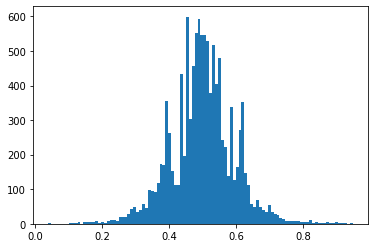

In [ ]:
print('--- ANNOTATIONS DATA ---')
ann_x = []
ann_y = []
for ann in annotations_train:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- VALIDATION DATA ---')
ann_x = []
ann_y = []
for ann in annotations_validation:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

In [ ]:
contador = 0
for img in X:
  if img[0].tolist() == [0,0,0,0,0,0,0,0,0,0,0,0,0] and img[1].tolist() == [0,0,0,0,0,0,0,0,0,0,0,0,0]:
    contador += 1

print(contador)

contador = 0
for img in images_train:
  if img[0].tolist() == [0,0,0,0,0,0,0,0,0,0,0,0,0] and img[1].tolist() == [0,0,0,0,0,0,0,0,0,0,0,0,0]:
    contador += 1

print(contador)

contador = 0
for img in images_validation:
  if img[0].tolist() == [0,0,0,0,0,0,0,0,0,0,0,0,0] and img[1].tolist() == [0,0,0,0,0,0,0,0,0,0,0,0,0]:
    contador += 1

print(contador)

0
0
0


In [ ]:
'''
  Hacer secuencias a partir de los vectores de 13 puntos que tenemos. 
'''
'''
X = np.array([1,2,3,4,5,6,7,8,9,10])
Y = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])



print(X[0::2])
print(X.shape)


X = X.reshape(5,2,1)
print(X)
print('-------')
print(Y[1::2])
print('-------')
'''
 '''
print(len(array_imgs))
print(np.array(array_imgs).shape)
#X = np.array(array_imgs).reshape(9686, 2, 13, 1)
#X = np.array(array_imgs).reshape(10914, 5, 13)
#X = np.array(new_array_imgs).reshape(8857, 5, 13)
X = np.array(new_array_imgs).reshape(22140, 2, 13)
# X = np.array(array_imgs).reshape(4843, 4, 13)


x_1 = []
x_2 = []
x_3 = []
x_4 = []
x_5 = []
sequences_array_imgs = []
'''
'''
#for i, image in enumerate(array_imgs):
for i, image in enumerate(new_array_imgs):
  x_1.append(image)
  if i > 0:
    x_2.append(image)
  if i > 1:
    x_3.append(image)
  if i > 3:
    x_4.append(image)
  if i > 4:
    x_5.append(image)


  if len(x_1) == 5:
    sequences_array_imgs.append(x_1)
    x_1 = []
  if len(x_2) == 5:
    sequences_array_imgs.append(x_2)
    x_2 = []
  if len(x_3) == 5:
    sequences_array_imgs.append(x_3)
    x_3 = []
  if len(x_4) == 5:
    sequences_array_imgs.append(x_4)
    x_4 = []
  if len(x_5) == 5:
    sequences_array_imgs.append(x_5)
    x_5 = []
'''
'''
for i, image in enumerate(new_array_imgs):
  x_1.append(image)
  if i > 0:
    x_2.append(image)

  if len(x_1) == 2:
    sequences_array_imgs.append(x_1)
    x_1 = []
  if len(x_2) == 2:
    sequences_array_imgs.append(x_2)
    x_2 = []

print('LENGTH:::::')
print(len(sequences_array_imgs))
print(sequences_array_imgs[0])

X = np.array(sequences_array_imgs)

print('-------')
print('-------')
print('-------')
print('X:')
print(X.shape)
print(X[0])
print('-------')
print('-------')
print('-------')
print('Y:')
#Y = np.array(normalized_annotations)
Y = np.array(new_array_annotations)
print(Y.shape)
#Y2=Y[1::2]
#Y=Y[1::4]
#Y=Y[4::1]
Y=Y[1::1]
print(Y.shape)
print()
print('-------')
print('-------')
print('-------')



import random
random_sort = random.sample(range(0, 33), 33)
print(len(random_sort))
print(random_sort)

new_array_imgs = []
new_array_annotations = []
for numb in random_sort:
  new_array_imgs += array_x[numb]
  new_array_annotations += array_y[numb]


print(len(new_array_imgs))
print(len(new_array_annotations))



split_test_train_value = 0.30
images_train, images_validation, annotations_train, annotations_validation = train_test_split(X, Y, test_size=split_test_train_value, random_state=42, shuffle=False)

print(annotations_train.shape)
print(annotations_validation.shape)

print(images_train.shape)
print(images_validation.shape)
'''


NameError: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,Conv2D,BatchNormalization,Dropout,ConvLSTM2D,Reshape,Activation,MaxPooling2D, LSTM, Input
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Adam

'''
run = wandb.init(project='behavior-studio',
           config={
              "learning_rate": 0.0001,
              "epochs": 500,
              "batch_size": 50,
              "loss_function": "mse",
              "architecture": "lstm",
              "dataset": "extreme dataset"
           })
config = wandb.config
'''

# LSMT MODEL with Dropout
def lstm_model(input_shape):
    model = Sequential()

    model.add(LSTM(20, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(20, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(20))
    model.add(Dropout(0.2))
    model.add(Dense(2))
    #adam = Adam(lr=config.learning_rate)
    adam = Adam(lr=0.0001)
    #model.compile(optimizer=adam, loss=config.loss_function, metrics=['mse', 'mae'])
    model.compile(optimizer=adam, loss="mse", metrics=['mse', 'mae'])
    return model

'''
def lstm_model(input_shape):
    model = Sequential()

    model.add(LSTM(20, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(20))
    model.add(Dense(2))
    adam = Adam(lr=config.learning_rate)
    model.compile(optimizer=adam, loss=config.loss_function, metrics=['mse', 'mae'])
    return model
'''


"\ndef lstm_model(input_shape):\n    model = Sequential()\n\n    model.add(LSTM(20, input_shape=input_shape, return_sequences=True))\n    model.add(LSTM(20, return_sequences=True))\n    model.add(LSTM(20))\n    model.add(Dense(2))\n    adam = Adam(lr=config.learning_rate)\n    model.compile(optimizer=adam, loss=config.loss_function, metrics=['mse', 'mae'])\n    return model\n"

In [ ]:
import time
from keras.backend import clear_session
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
print(images_train.shape)
print(images_validation.shape)
print(images_train[0].shape)
print(annotations_train[0])

#input_shape = (4, 13)
#input_shape = (5, 13)
#input_shape = (2, 13)
input_shape = (3, 13)
#print(img_shape)


#timesteps = 1
#batch_size = config.batch_size  # 16
batch_size = 50
#nb_epoch = config.epochs
nb_epoch = 300
# model = lstm_model(img_shape, 'cropped', batch_size, timesteps)
model_name = 'lstm'
clear_session()
model = lstm_model(input_shape)
model_filename = timestr + '_lstm_13_points_3_examples_1_sample_weight_300_epochs_new_normalized'


if type_image == 'cropped':
    model_file = '/content/drive/My Drive/' + model_filename + '.h5'


# Print layers
print(model)
model.build(input_shape)
print(model.summary())

import datetime
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, CSVLogger

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping=EarlyStopping(monitor="mae", patience=40, verbose=1, mode='auto')
# Create a callback that saves the model's weights
checkpoint_path = "/content/drive/My Drive/" + model_filename + '_cp.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
csv_logger = CSVLogger("/content/drive/My Drive/" + model_filename + '.csv', append=True)

# Train
#model_history = model.fit(images_train, annotations_train, epochs=nb_epoch, sample_weight=sample_weight, batch_size=batch_size, verbose=2, validation_data=(images_validation, annotations_validation), callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger, WandbCallback()])
model_history = model.fit(images_train, annotations_train, epochs=nb_epoch, sample_weight=sample_weight, batch_size=batch_size, verbose=2, validation_data=(images_validation, annotations_validation), callbacks=[tensorboard_callback, earlystopping, cp_callback, csv_logger])

# Save the model
model.save(model_file)

# Evaluate the model
score = model.evaluate(images_validation, annotations_validation, verbose=0)

print('Evaluating')
print('Test loss: ', score[0])
print('Test mean squared error: ', score[1])
print('Test mean absolute error: ', score[2])


# SAVE METADATA
from tensorflow.python.keras.saving import hdf5_format
import h5py

model_path = model_file
# Save model
with h5py.File(model_path, mode='w') as f:
    hdf5_format.save_model_to_hdf5(model, f)
    f.attrs['experiment_name'] = ''
    f.attrs['experiment_description'] = ''
    f.attrs['batch_size'] = batch_size
    f.attrs['nb_epoch'] = nb_epoch
    f.attrs['model'] = model_name
    f.attrs['img_shape'] = img_shape
    f.attrs['normalized_dataset'] = True
    f.attrs['sequences_dataset'] = True
    f.attrs['gpu_trained'] = True
    f.attrs['data_augmentation'] = True
    f.attrs['extreme_data'] = False
    f.attrs['split_test_train'] = 0.30
    f.attrs['instances_number'] = len(array_annotations)
    f.attrs['loss'] = score[0]
    f.attrs['mse'] = score[1]
    f.attrs['mae'] = score[2]
    f.attrs['csv_path'] = model_filename + '.csv'

# run.join()

20210608-072354
(26613, 3, 13)
(11406, 3, 13)
(3, 13)
[0.70588235 0.528181  ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 20)            2720      
_________________________________________________________________
dropout (Dropout)            (None, 25, 20)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 20)            3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 20)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

--- ANNOTATIONS PREDICTIONS ---


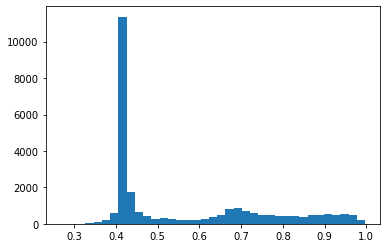

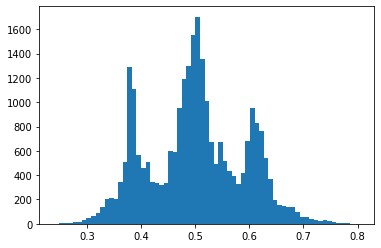

--- ANNOTATIONS DATA ---


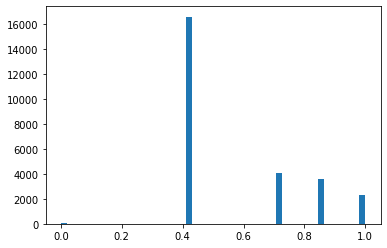

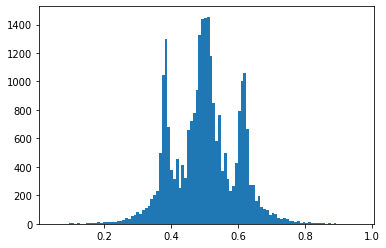

--- VALIDATION PREDICTIONS ---


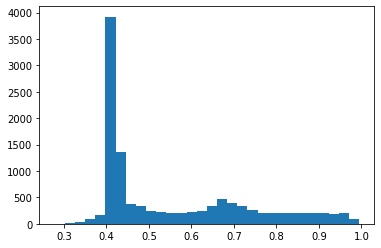

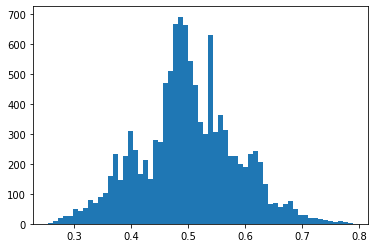

--- VALIDATION DATA ---


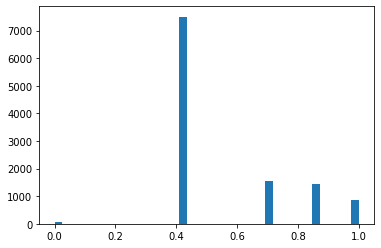

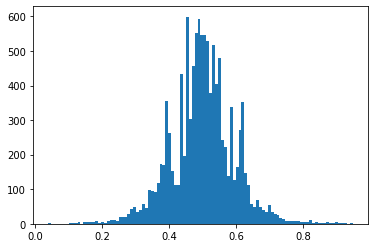

In [ ]:
from keras.models import load_model
regression_model = load_model('/content/drive/My Drive/20210608-072354_lstm_13_points_3_examples_1_sample_weight_300_epochs_new_normalized.h5')
predictions_train = regression_model.predict(images_train)
predictions_validation = regression_model.predict(images_validation)

print('--- ANNOTATIONS PREDICTIONS ---')
ann_x = []
ann_y = []
for ann in predictions_train:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- ANNOTATIONS DATA ---')
ann_x = []
ann_y = []
for ann in annotations_train:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()

print('--- VALIDATION PREDICTIONS ---')
ann_x = []
ann_y = []
for ann in predictions_validation:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()


print('--- VALIDATION DATA ---')
ann_x = []
ann_y = []
for ann in annotations_validation:
  ann_x.append(ann[0])
  ann_y.append(ann[1])

n, bins, patches = plt.hist(x=ann_x, bins='auto')
plt.show()
n, bins, patches = plt.hist(x=ann_y, bins='auto')
plt.show()


In [ ]:
!python -V

Python 3.7.10


In [ ]:
!pip show numpy
!pip show keras
!pip show tensorflow

Name: numpy
Version: 1.19.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, wordcloud, torchvision, torchtext, torch, tifffile, thinc, Theano, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, resampy, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc3, pyerfa, pyemd, pyarrow, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-contrib-python, numexpr, numba, np-utils, nibabel, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lightgbm, librosa, knnimpute, Keras, Keras-Preprocessing, kapre, jpeg4py, jaxlib, jax, imgaug, imbalanced-learn, imageio, hyperopt, holoviews, h5py, gym, gensim, folium, fix-yahoo-finance

In [ ]:
Y = [1,2,3,4]
print(Y)
Y = Y[1:4:]
print(Y)
Y.append(5)
print(Y)

[1, 2, 3, 4]
[2, 3, 4]
[2, 3, 4, 5]


[0.4159564  0.59062576]
[[0.      0.325   0.125   0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.      0.29375 0.1     0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]
 [0.      0.2625  0.075   0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.     ]]
[0.41176471 0.64885349]


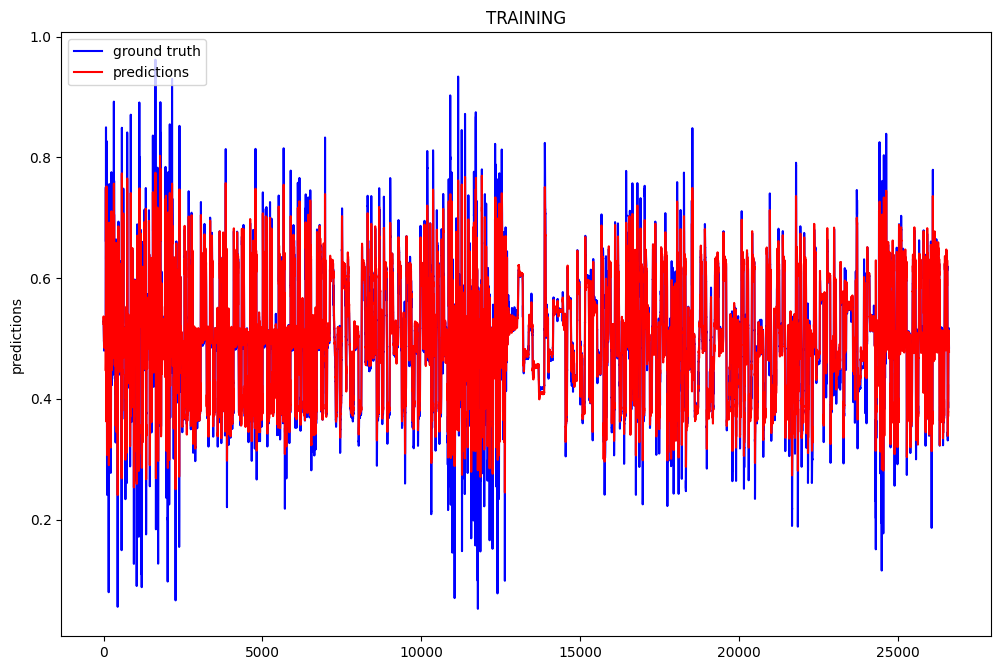

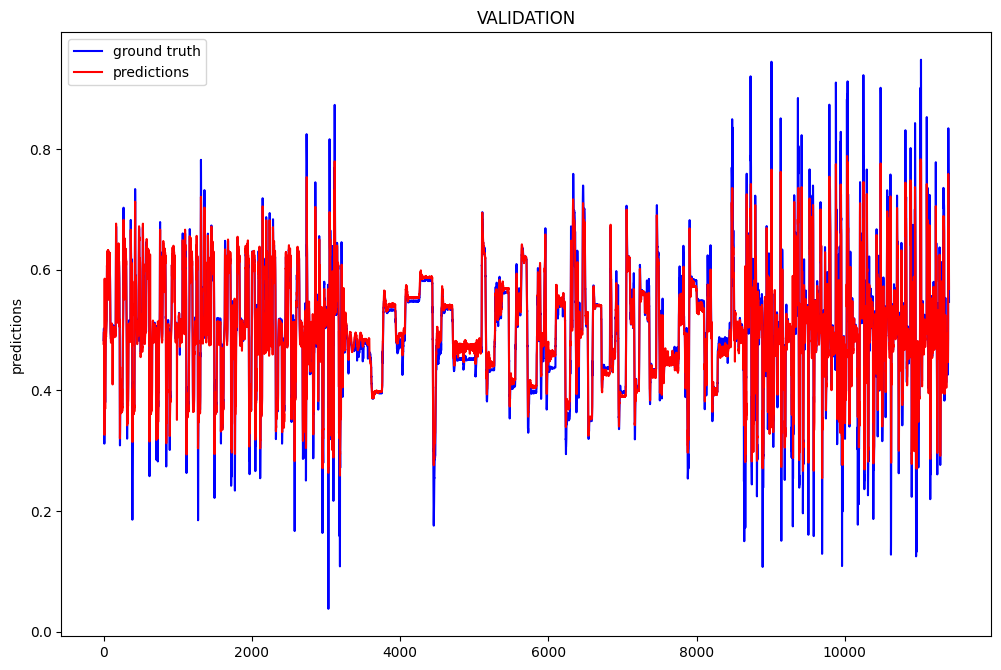

In [ ]:
import matplotlib.pyplot as plt

predictions_train = regression_model.predict(images_train)
predictions_validation = regression_model.predict(images_validation)
#predictions_validation = regression_model.predict(images_validation[11000::1])


print(predictions_train[100])
#print(predictions_train[:,1])

print(images_train[100])
print(annotations_train[100])
#print(images_train[:,1])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_train[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('TRAINING')
plt.show()


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(annotations_validation[:,1], "-b", label="ground truth")
#plt.plot(annotations_validation[11000::1,1], "-b", label="ground truth")
plt.plot(predictions_validation[:,1], "-r", label="predictions")
#plt.plot(predictions_validation[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('VALIDATION')
plt.show()


In [ ]:
print(predictions_validation.shape)
print(annotations_validation[10000])
print(images_validation[10000])

(11389, 2)
[0.41176471 0.23122872]
[[0.      0.3625  0.40625 0.4     0.3875  0.38125 0.375   0.36875 0.3625
  0.35    0.3375  0.325   0.3125 ]
 [0.      0.4625  0.48125 0.48125 0.475   0.475   0.475   0.475   0.475
  0.475   0.475   0.46875 0.46875]
 [0.      0.4875  0.5     0.50625 0.5125  0.51875 0.53125 0.5375  0.54375
  0.55625 0.5625  0.56875 0.575  ]
 [0.      0.5     0.5125  0.525   0.54375 0.55625 0.56875 0.5875  0.6
  0.61875 0.63125 0.65    0.6625 ]
 [0.      0.50625 0.525   0.54375 0.55625 0.575   0.59375 0.6125  0.63125
  0.65    0.675   0.6875  0.70625]]


In [ ]:
!ls "/content/drive/My Drive"
#!unzip "/content/drive/My Drive/simple_circuit_dataset.zip"
#!ls "/content/drive/My Drive"
#!unzip "/content/drive/My Drive/many_curves_dataset.zip"
!unzip "/content/drive/My Drive/montmelo_data.zip"


 20210215-134322_model_lstm_sequence_test_cp.h5
 20210215-134322_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test_cp.h5
 20210215-134625_model_lstm_sequence_test.csv
 20210215-134625_model_lstm_sequence_test.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence_cp.h5
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.csv
 20210215-180738_deepest_lstm_tinypilotnet_model_sequence.h5
 20210216-084753_tinypilotnet_lstm_model_sequence_cp.h5
 20210216-084753_tinypilotnet_lstm_model_sequence.csv
 20210216-084753_tinypilotnet_lstm_model_sequence.h5
 20210216-091101_tinypilotnet_model_sequence_cp.h5
 20210216-091101_tinypilotnet_model_sequence.csv
 20210216-091101_tinypilotnet_model_sequence.h5
 20210216-095459_pilotnet_model_model_sequence_cp.h5
 20210216-095459_pilotnet_model_model_sequence.csv
 20210216-095459_pilotnet_model_model_sequence.h5
 20210219-082603_deepest_lstm_tinypilotnet_model_RGB_sequence_cp.h5
 20210219-082603_deepest_lstm_tinypilotnet_mode

In [ ]:
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import json


def load_data_new_dataset(folder):
    name_folder = '/content/' + folder + '/'
    #list_images = glob.glob(name_folder + '*.png')
    list_images = glob.glob(name_folder + '*.jpg')
    print(list_images)
    images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.jpg')[0]))
    #images = sorted(list_images, key=lambda x: int(x.split('/')[3].split('.png')[0]))
    name_file = '/content/' + folder + '/data.json'
    json_file = open(name_file, 'r')
    data = json.load(json_file)
    json_file.close()
    return images, data

def parse_json_new_dataset(data, array):
    # Process json
    for value in data:
      v = value['v']
      w = value['w']
      array.append((float(v), float(w)))
    '''
    for key, value in data.items():
      v = data[key]['v']
      w = data[key]['w']
      array.append((float(v), float(w)))
    '''
    return array

array_imgs = []
array_annotations = []

#images_simple, data_simple = load_data_new_dataset('simple_circuit_dataset')
#images_many_curves, data_many_curves = load_data_new_dataset('many_curves_dataset')
images_montmelo, data_montmelo = load_data_new_dataset('montmelo_data')
print(images_montmelo)

#array_imgs, broken_imgs_simple = get_images(images_simple, type_image, array_imgs, 'rgb')
#array_imgs, broken_imgs_many_curves = get_images(images_many_curves, type_image, array_imgs, 'rgb')
array_imgs, broken_imgs_montmelo = get_images(images_montmelo, type_image, array_imgs, 'rgb')

#array_annotations = parse_json_new_dataset(data_simple, array_annotations)
#array_annotations = parse_json_new_dataset(data_many_curves, array_annotations)
array_annotations = parse_json_new_dataset(data_montmelo, array_annotations)

# array_annotations, simple_images = preprocess_data(array_annotations, simple_images)

normalized_imgs = []
for img in array_imgs:
  new_img = []
  for x in img:
    x = (x - 0) / 160 * 1 + 0
    new_img.append(x)

  normalized_imgs.append(new_img)
# x = x[:]


# START NORMALIZE DATA
array_annotations_v = []
array_annotations_w = []

for annotation in array_annotations:
  array_annotations_v.append(annotation[0])
  array_annotations_w.append(annotation[1])
  
array_annotations_v = np.stack(array_annotations_v, axis=0)
array_annotations_v = array_annotations_v.reshape(-1, 1)

array_annotations_w = np.stack(array_annotations_w, axis=0)
array_annotations_w = array_annotations_w.reshape(-1, 1)

def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))
normalized_X = normalize(array_annotations_v)
normalized_Y = normalize(array_annotations_w)
'''
old_min = array_annotations_w.min()
old_range = array_annotations_w.max() - old_min

new_min = -1
new_range = 2
normalized_Y = [(n - old_min) / old_range * new_range + new_min for n in array_annotations_w]
normalized_Y = np.array(normalized_Y)
'''
normalized_annotations = []
for i in range(0, len(normalized_X)):
  normalized_annotations.append([normalized_X.item(i), normalized_Y.item(i)])

normalized_annotations = np.stack(normalized_annotations, axis=0)

normalized_X = []
normalized_Y = []
# END NORMALIZE DATA
print(len(normalized_imgs))
print(len(normalized_annotations))

array_imgs = normalized_imgs
array_annotations = normalized_annotations

['/content/montmelo_data/3290.jpg', '/content/montmelo_data/2798.jpg', '/content/montmelo_data/1021.jpg', '/content/montmelo_data/1165.jpg', '/content/montmelo_data/2776.jpg', '/content/montmelo_data/879.jpg', '/content/montmelo_data/232.jpg', '/content/montmelo_data/2502.jpg', '/content/montmelo_data/1994.jpg', '/content/montmelo_data/911.jpg', '/content/montmelo_data/2348.jpg', '/content/montmelo_data/183.jpg', '/content/montmelo_data/2997.jpg', '/content/montmelo_data/1240.jpg', '/content/montmelo_data/993.jpg', '/content/montmelo_data/2621.jpg', '/content/montmelo_data/361.jpg', '/content/montmelo_data/567.jpg', '/content/montmelo_data/289.jpg', '/content/montmelo_data/3530.jpg', '/content/montmelo_data/2595.jpg', '/content/montmelo_data/2781.jpg', '/content/montmelo_data/1195.jpg', '/content/montmelo_data/994.jpg', '/content/montmelo_data/960.jpg', '/content/montmelo_data/2920.jpg', '/content/montmelo_data/679.jpg', '/content/montmelo_data/1532.jpg', '/content/montmelo_data/3055.j

In [ ]:
sequence_array_imgs = []
sequence_array_anns = []
x_1 = []
x_2 = []
x_3 = []


for i, image in enumerate(array_imgs):
  x_1.insert(0, image)
  if i > 0:
    x_2.insert(0, image)
  if i > 1:
    x_3.insert(0, image)

  if len(x_1) == 3:
    sequence_array_imgs.append(x_1)
    x_1 = []
  if len(x_2) == 3:
    sequence_array_imgs.append(x_2)
    x_2 = []
  if len(x_3) == 3:
    sequence_array_imgs.append(x_3)
    x_3 = []
 

print(len(sequence_array_imgs))
new_array_y = array_annotations[2::1]
print(len(new_array_y))


3581
3581


(3581, 3, 13)
[0.7973844 0.5132147]
[[0.      0.4875  0.48125 0.4875  0.475   0.4625  0.4625  0.4625  0.45
  0.44375 0.44375 0.44375 0.4375 ]
 [0.      0.4875  0.48125 0.4875  0.475   0.4625  0.4625  0.4625  0.45
  0.44375 0.44375 0.44375 0.4375 ]
 [0.      0.4875  0.48125 0.4875  0.475   0.4625  0.4625  0.4625  0.45
  0.44375 0.44375 0.44375 0.4375 ]]
[0.41176471 0.52057406]


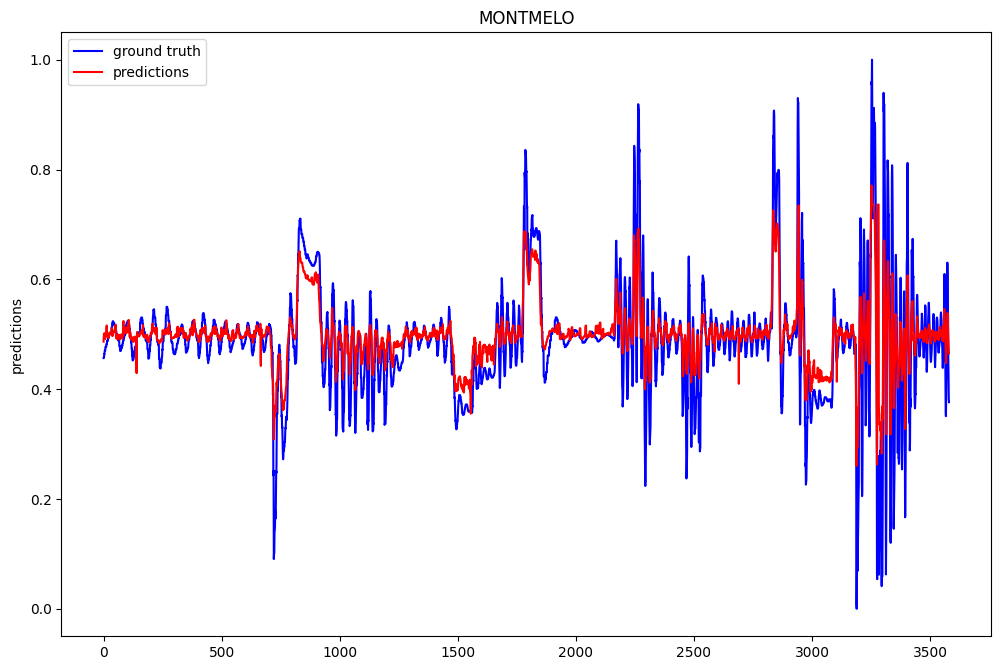

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
regression_model = load_model('/content/drive/My Drive/20210608-072354_lstm_13_points_3_examples_1_sample_weight_300_epochs_new_normalized.h5')


sequence_array_imgs = np.stack(sequence_array_imgs, axis=0)
print(sequence_array_imgs.shape)
predictions_train = regression_model.predict(sequence_array_imgs)

print(predictions_train[100])
#print(predictions_train[:,1])

print(sequence_array_imgs[100])
print(new_array_y[100])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(new_array_y[:,1], "-b", label="ground truth")
plt.plot(predictions_train[:,1], "-r", label="predictions")
plt.legend(loc="upper left")
plt.ylabel('predictions')
plt.title('MONTMELO')
plt.show()
